# Naive Bayes on Amazon Fine food Reviews
1) Apply Naive Bayes.                     
2) Find the Right alpha using C.V.                    
3) Get feature importance for +ve & -ve classes.               
4) Report with these performance metrics (Accuracy,Confusion Matrix,Precision,Recall,F1-Score).            

In [1]:
# importing the libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import string

#from sklearn.feature_extraction.text import TfidfTransformer
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.metrics import confusion_matrix
#from sklearn import metrics
#from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


In [2]:
# loading the dataset

con = sqlite3.connect("/Users/abhinavkunta/Desktop/DataSets/amazon-fine-food-reviews/database.sqlite")

In [3]:
filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score  != 3",con)

In [4]:
# EDA


df = pd.read_sql_query("SELECT * FROM Reviews WHERE HelpfulnessNumerator > HelpfulnessDenominator",con)

In [5]:
# giving rating according to the score

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
rating = filtered_data['Score']
positiveneg = rating.map(partition) 
filtered_data['Score'] = positiveneg

In [6]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
# data deduplication
final = filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [11]:
final.shape

(364173, 10)

In [12]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [13]:
# here we are only considering the subset of reviews by random sampling as it is lot of time consuming for 500k reviews.

# sampling the positive reviews
finalp = final[final.Score == 'positive']
finalp = finalp.sample(frac=0.035,random_state=1) 

# sampling the negative reviews
finaln = final[final.Score == 'negative']
finaln = finaln.sample(frac=0.15,random_state=1) 

# concatinating both the samples
final = pd.concat([finalp,finaln],axis=0) 

In [14]:
final.shape

(19313, 10)

In [15]:
# sorting is done according to time because the reviews change by time-time and more over we havevtimestamps available.

final = final.sort_values("Time",axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

In [16]:
# checking the number of positiveb and negative ratings.

final['Score'].value_counts()



positive    10747
negative     8566
Name: Score, dtype: int64

In [17]:
# preprocessing = stopword removal, stemming, lemmitization.
# removal of html tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

0
I am continually amazed at the shoddy treatment that some movies get in their DVD release.  This DVD is simply a disgrace, especially considering what a great movie this is.  I give the movie itself 5 stars; it's a wonderful example of Tim Burton's energy and style.<p>This DVD has no extras worth mentioning.  No deleted scenes, no featurettes, not even a lousy commentary track!  To make it even worse, the film has been CUT DOWN from the theatrical release!  I have never seen a DVD release before where you get LESS than was originally presented in theaters.<p>My advice is to save your money until somebody figures out that when a movie is released on DVD, it needs to live up to the capabilities of the medium, and should always provide more material than was originally released, not less.


In [18]:
# downloading set of stopwords in english
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinavkunta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# set of stop words
stop = set(stopwords.words('english'))
print(stop)

{'hers', 'm', 'have', 'i', 'being', 'won', 's', 'couldn', 'you', 'can', 'all', 'any', 'her', 'further', 'when', 'to', 'only', 'mustn', "aren't", 'ours', 'the', "needn't", 'below', 'a', 'how', 'after', 'so', 'just', 'themselves', 'ma', 'before', 'as', 'each', 'been', 'in', 'is', 've', 'these', 'on', 'wasn', 'while', 'yours', 'she', 'my', 'whom', 'by', 'himself', 'what', "you'd", "didn't", "she's", 't', 'under', 'hasn', "won't", "doesn't", 'down', 'shouldn', 'into', 'who', 'no', 'out', 'didn', 'aren', "that'll", 'at', 'which', 'there', 'our', 'were', 'don', 'be', 'off', 'o', 'very', 'had', "mustn't", 'yourselves', 'through', 'weren', "shouldn't", 'that', 'such', 'them', 'other', 'both', 'nor', 'they', "haven't", 'until', 'did', 'up', 'herself', 'him', 'if', 'of', "hadn't", 'more', 'll', "weren't", 'again', 'for', "wasn't", 'their', 'its', "you've", 'his', 'am', 'shan', 'are', 'not', 'some', 'theirs', 'then', 'here', 'isn', 'from', 'mightn', 'd', 'do', "couldn't", 'own', 're', 'where', 'o

In [20]:
%%time
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'hers', 'm', 'have', 'i', 'being', 'won', 's', 'couldn', 'you', 'can', 'all', 'any', 'her', 'further', 'when', 'to', 'only', 'mustn', "aren't", 'ours', 'the', "needn't", 'below', 'a', 'how', 'after', 'so', 'just', 'themselves', 'ma', 'before', 'as', 'each', 'been', 'in', 'is', 've', 'these', 'on', 'wasn', 'while', 'yours', 'she', 'my', 'whom', 'by', 'himself', 'what', "you'd", "didn't", "she's", 't', 'under', 'hasn', "won't", "doesn't", 'down', 'shouldn', 'into', 'who', 'no', 'out', 'didn', 'aren', "that'll", 'at', 'which', 'there', 'our', 'were', 'don', 'be', 'off', 'o', 'very', 'had', "mustn't", 'yourselves', 'through', 'weren', "shouldn't", 'that', 'such', 'them', 'other', 'both', 'nor', 'they', "haven't", 'until', 'did', 'up', 'herself', 'him', 'if', 'of', "hadn't", 'more', 'll', "weren't", 'again', 'for', "wasn't", 'their', 'its', "you've", 'his', 'am', 'shan', 'are', 'not', 'some', 'theirs', 'then', 'here', 'isn', 'from', 'mightn', 'd', 'do', "couldn't", 'own', 're', 'where', 'o

In [21]:
%%time
import os

if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in final['Text'].values:
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1
        final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

CPU times: user 71 µs, sys: 83 µs, total: 154 µs
Wall time: 79.9 µs


In [22]:
%%time
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1


CPU times: user 20.1 s, sys: 129 ms, total: 20.2 s
Wall time: 20.4 s


In [23]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the revie

In [24]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [27]:
# Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
final_bow_count = count_vect.fit_transform(final_string)

In [28]:
from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
# train and test split

import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = final_bow_np
y = final['Score']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(13519, 17934) (13519,)
(5794, 17934) (5794,)


In [109]:
# function for finding the right Alpha.


from sklearn.cross_validation import cross_val_score

def find_optimal_alpha(X_train,y_train, myList):
   
    #creating odd list of alpha for NB
    #myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for alpha in neighbors:
        nb = BernoulliNB(alpha=alpha)
        scores = cross_val_score(nb, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_alpha = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal alpha is %d.' % optimal_alpha)


    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. Alpha Value')
    plt.xlabel('Alpha')
    plt.ylabel('Error Rate')

    print("the misclassification error for each Alpha value is : ", np.round(MSE,3))
    
    return optimal_alpha




The optimal alpha is 1.
the misclassification error for each Alpha value is :  [0.18  0.214 0.254 0.29  0.322 0.351 0.375 0.39  0.403 0.413 0.42  0.427
 0.43  0.434 0.436 0.437 0.439 0.44  0.44  0.441]
CPU times: user 11 s, sys: 230 ms, total: 11.2 s
Wall time: 7.12 s


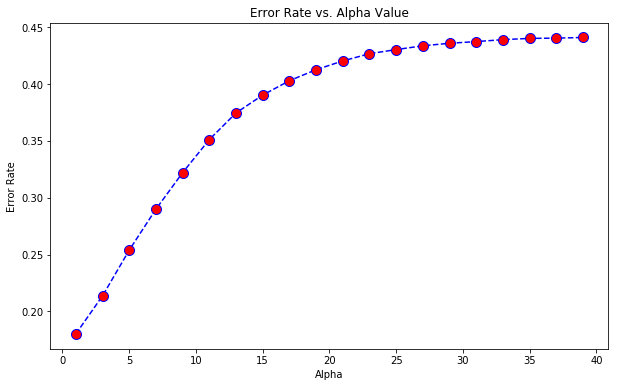

In [114]:
%%time
myList = list(range(0,40))

optimal_alpha = find_optimal_alpha(X_train ,y_train,myList)

In [129]:
import numpy as np
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(alpha=1.0)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

In [130]:
from sklearn.metrics import accuracy_score

print("Accuracy for Naive Bayes clasifier with Bag of words is ",round(accuracy_score(y_test ,pred),3))


Accuracy for Naive Bayes clasifier with Bag of words is  0.817


# Feature Importance for both positive and negative classes

In [131]:
# source:https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
# feature importance for positive and negative classes.

neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()

print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:20]))
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:20]))

['aaa' 'mas' 'masaman' 'mascot' 'masculin' 'mashbil' 'massachusett'
 'massaman' 'marukan' 'massimo' 'mastiff' 'mastopathi' 'matador' 'matccha'
 'mateljan' 'mater' 'materia' 'masterpiec' 'matine' 'martinelli']
['sambal' 'neglig' 'neglect' 'doze' 'rustichella' 'rustl' 'negit' 'ruta'
 'downtown' 'rutabaga' 'downsiz' 'dpsg' 'ruthless' 'downhil' 'needi'
 'downey' 'necklac' 'dowd' 'saaqin' 'neccessarili']


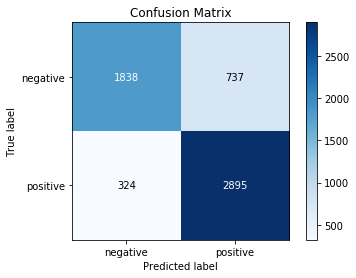

In [132]:
# confusion matrix.

import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_test ,pred)


In [133]:
# precision, recall, F1 score
from sklearn.metrics import classification_report
print(classification_report(y_test ,pred))


             precision    recall  f1-score   support

   negative       0.85      0.71      0.78      2575
   positive       0.80      0.90      0.85      3219

avg / total       0.82      0.82      0.81      5794



# The optimal alpha is found to be "1". Accuracy achieved in classification by Naive Bayes classifier on Amazon Reviews Dataset is 81.7% by using BoW model.